In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load dataset
data = np.array(pd.read_csv('../../datasets/A_Z Handwritten Data/A_Z Handwritten Data.csv'))

In [3]:
#get X and y
X, y = data[:, 1:], data[:, 0]

In [4]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
print(X.shape)
print(y.shape)

(372450, 784)
(372450,)


In [6]:
#image transformer
from sklearn.base import BaseEstimator, TransformerMixin

class ImageTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, width=14, height=14,  is_img=False):
        self.width = width
        self.height = height
        self.is_img = is_img
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.is_img:
            images = []
            # load the image and convert to grayscale
            for img in X:                
                
                image = img.convert('L').resize((self.width, self.height))
                
                enhancer = ImageEnhance.Contrast(image)
                image = enhancer.enhance(1.0)
                
                images.append(np.asarray(image).reshape(-1))
            return np.array(images)
        else:
            return X

In [7]:
#preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('image_transformer', ImageTransformer()),
    ('scaler', StandardScaler())
])

print(pipe.get_params().keys())

width, height = 28, 28
pipe.set_params(image_transformer__width=width, image_transformer__height=height, image_transformer__is_img=False)
X_train_proc = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

dict_keys(['memory', 'steps', 'verbose', 'image_transformer', 'scaler', 'image_transformer__height', 'image_transformer__is_img', 'image_transformer__width', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std'])


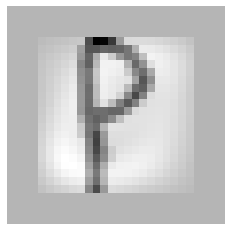

In [8]:
random_letter = X_train_proc[9238]
random_letter_image = random_letter.reshape(28, 28)

plt.imshow(random_letter_image, cmap="binary")
plt.axis("off")
plt.show()

In [9]:
#classifier and metrics
from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.metrics import accuracy_score, plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

log_clf = LogisticRegression(max_iter=1000, n_jobs=-1) #not used in voting classifier
knn_clf = KNeighborsClassifier(n_jobs=-1)
svm_clf = SVC(probability=True)
rnd_clf = RandomForestClassifier(n_jobs=-1)
ext_clf = ExtraTreesClassifier(n_jobs=-1)

In [ ]:
#log reg - not used bc of low accuracy in comparison (~80% on 100000 samples)
log_clf.fit(X_train_proc[:100000], y_train[:100000])
scores = cross_val_score(log_clf, X_train_proc[:100000], y_train[:100000], cv=5)
print("Cross-Val:" ,scores.mean())

In [10]:
#knn
knn_clf.fit(X_train_proc[:100000], y_train[:100000])
scores = cross_val_score(knn_clf, X_train_proc[:100000], y_train[:100000], cv=5)
print("Cross-Val:" ,scores.mean())

Cross-Val: 0.9290799999999999


In [11]:
#random forest
rnd_clf.fit(X_train_proc[:100000], y_train[:100000])
scores = cross_val_score(rnd_clf, X_train_proc[:100000], y_train[:100000], cv=5)
print("Cross-Val:" ,scores.mean())

Cross-Val: 0.9538


In [12]:
#extra trees
ext_clf.fit(X_train_proc[:150000], y_train[:150000])
scores = cross_val_score(ext_clf, X_train_proc[:150000], y_train[:150000], cv=5)
print("Cross-Val:" ,scores.mean())

Cross-Val: 0.9629999999999999


In [13]:
#svm
svm_clf.fit(X_train_proc[:50000], y_train[:50000])
scores = cross_val_score(svm_clf, X_train_proc[:50000], y_train[:50000], cv=3)
print("Cross-Val:" ,scores.mean())

Cross-Val: 0.9427600695555992


In [14]:
#Voting classifier
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('rndf', rnd_clf), ('knn', knn_clf), ('svm', svm_clf), ('erndf', ext_clf)],
    voting='soft')
voting_clf.fit(X_train_proc[:100000], y_train[:100000])
voting_clf.score(X_test[:100000], y_test[:100000])

0.9683447442609746

In [ ]:
#ERROR ANALYSIS using confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(voting_clf, X_train_proc, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

#image representation of the confusion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
#plot on the error
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
#seaborn plot
sns.heatmap(conf_mx, annot=True)

In [ ]:
#image augumentation on flawed classes // adding more flawed classes to training data

In [ ]:
#testing out sole predictions

In [ ]:
#optional stuff:

In [ ]:
#xgboost classifier
from xgboost import XGBClassifier

xbg = XGBClassifier()
xbg.fit(X_train_proc[:100000], y_train[:100000], 
           eval_set=[(X_test[:100000], y_test[:100000])], early_stopping_rounds=2)
y_pred = xbg.predict(X_test[:100000])
accuracy_score(y_test[:100000], y_pred)

In [ ]:
#bagging clf for better scaling of svc
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

n_estimators = 10
clf = OneVsRestClassifier(BaggingClassifier(LinearSVC(probability=True, class_weight='auto'), max_samples=1.0 / n_estimators, n_estimators=n_estimators))
clf.fit(X_train_proc[:10000], y_train[:10000])
print(clf.score(X_test[:10000],y_test[:10000]))
proba = clf.predict_proba(X_test[:10000])